In [1]:
# import numpy as np
# import matplotlib.pyplot as plt

# # ==== 假设的能量 bins 与对应概率 ====
# bins = np.array([0,   10,   20,  30, 40,  50,    60,   70, 80])  # keV
# pdf = np.array([0.01, 0.09, 0.2, 0,  0.4, 0.1, 0.15, 0.05])  # 每个区间的相对概率

# # 归一化
# pdf = pdf / pdf.sum()

# # 计算累积分布函数（CDF）
# cdf = np.cumsum(pdf)
# bin_centers = (bins[:-1] + bins[1:]) / 2

# # ==== 画图 ====
# fig, ax = plt.subplots(2, 1, figsize=(6, 5))

# # 上图：PDF（概率密度）
# ax[0].bar(bin_centers, pdf, width=8, color='skyblue', edgecolor='k')
# ax[0].set_title('PDF: Energy Probability Distribution')
# ax[0].set_xlabel('Energy (keV)')
# ax[0].set_ylabel('Probability')

# # 下图：CDF（累积分布函数）
# ax[1].step(bin_centers, cdf, where='mid', color='orange', label='CDF')
# ax[1].set_xlabel('Energy (keV)')
# ax[1].set_ylabel('Cumulative Probability')
# ax[1].set_ylim(0, 1.05)

# # 示意几个随机数 u
# u = np.array([0.05, 0.75, 0.25, 0.55, 0.85])
# idx = np.searchsorted(cdf, u)

# # 在CDF图上画出这些随机数与对应能量区间
# for ui, i in zip(u, idx):
#     ax[1].hlines(ui, 0, bin_centers[i], color='gray', linestyle='--')
#     ax[1].vlines(bin_centers[i], 0, ui, color='gray', linestyle='--')
#     ax[1].plot(bin_centers[i], ui, 'ro')
#     ax[1].text(bin_centers[i]+1, ui+0.02, f'idx={i}', fontsize=9)

# plt.tight_layout()
# plt.show()

# print("随机数 u:", u)
# print("cdf:", cdf)
# print("对应索引 idx:", idx)
# print("对应能量 bin centers:", bin_centers[idx])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from poisson_signal_generator_utils import generate_signal, count_crossings

## 待做：找一找 asci 本底噪声电子噪声的信号波形，来做模拟
 

# 1) 读取理论光谱文件
data = np.loadtxt('spectrum_file/spek_120.txt', 
                  skiprows=1)   # skiprows=1，跳过第一行
energies = data[:,0]            # 能量点，单位 keV  
values = data[:,1]              # 对应归一化强度 N[keV cm^2 mAs]^-1 @ 1 meter


# 2) 光源物理参数
I_mA   = 20.0                   # 管电流            [mA] 
r_m    = 0.40                   # 源到探测器距离     [m]
pixel_length  = 340e-6           # 单像素尺寸340um，  [cm] 
A_cm2  = (pixel_length * 100.0)**2    # m->cm，面积用 cm^2
# dE     = 1                      # 能量间隔

# 3） 芯片参数设置
pulse   = 5e-9                   # 信号脉宽 25ns      [s]
delta_t = 1e-9                    # 采样帧频率 1ns     [s]
integral_time = 400e-6            # 信号积分时间 400us [s]
amp    = 1                      # 探测器对光源的放大系数

# 4) 构建坐标轴 计算入射计数率 λ（counts/s）
# pdf = values.copy()     # values 是归一化的光谱
# bins = np.arange(energies.min(), energies.max() + 1e-6, 1.0)   # edges every 1 keV
# ---------- 用中心能量构造“边界” -> 保证 bins 长度 = N+1, pdf 长度 = N ----------
mid = (energies[:-1] + energies[1:]) / 2
bins = np.empty(len(energies) + 1)
bins[1:-1] = mid
bins[0]    = energies[0]  - (mid[0]     - energies[0])
bins[-1]   = energies[-1] + (energies[-1] - mid[-1])
dE  = np.diff(bins)         # 每个 bin 的宽度 (通常 ~1 keV)
pdf = values * dE           # 先乘 dE 再归一化，更严谨
pdf = pdf / pdf.sum()       # 现在 pdf 的长度是 N，和 bins 对齐


rate = np.sum(values * dE * I_mA * (1.0/r_m)**2 * A_cm2)
chip_rate = amp * rate          # 进入芯片的计数率

 

def spectrum_from_signal(sig, n_thr=256):
    thr_min = 1.0
    thr_max = sig.max() #* 1.05
    thr_vals = np.linspace( thr_min, thr_max, n_thr)
    integral_counts = np.array([count_crossings(sig, thr) for thr in thr_vals])

    # integral = np.array([(sig >= t).sum() for t in thr])  # 或你的穿越计数器
    # 轻微平滑可选：from scipy.signal import savgol_filter; integral = savgol_filter(integral, 21, 3)
    differential = -np.gradient(integral_counts, thr_vals)
    return thr_vals, integral_counts, differential


# 5） 根据 归一化的 谱，产生时间信号
n_runs = 5   # 重复次数
integrals, differentials = [], []

for _ in range(n_runs):
    t, sig, times, amps = generate_signal(bins, pdf, chip_rate, 
                                      integral_time, 
                                      pulse,     # 脉宽 
                                      delta_t,              # 1ns
                                      gain=1.0,
                                      pulse_shape='gauss'
                                      )
    thr, integ, diff = spectrum_from_signal(sig)
    integrals.append(integ)
    differentials.append(diff) 

thr_vals = thr
integral_avg     = np.mean(integrals, axis=0)
differential_avg = np.mean(differentials, axis=0)

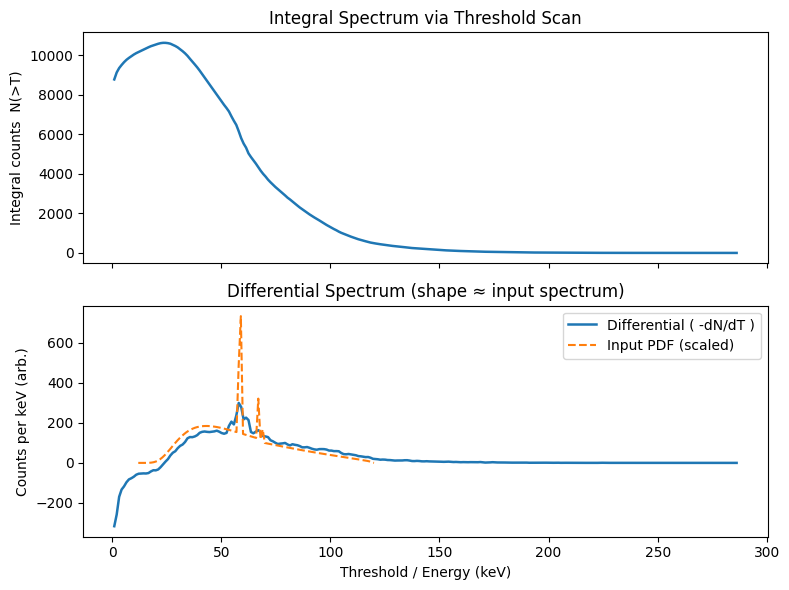

In [ ]:
energy_axis = thr_vals  # keV（在你的 generate_signal 里 gain=1.0）

# --- 画图：积分谱 & 微分谱（与输入pdf作形状对比）---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# 积分谱（阈值越高，计数越少）
ax1.plot(energy_axis, integral_avg, lw=1.8)
ax1.set_ylabel('Integral counts  N(>T)')
ax1.set_title('Integral Spectrum via Threshold Scan')

# 微分谱（应近似输入能谱形状；仅差一个尺度因子）
ax2.plot(energy_axis, differential_avg, lw=1.8, label='Differential ( -dN/dT )')

# 可选：把输入 pdf 归一后缩放到可见范围作对比（仅形状对比）
# 这里简单按最大值对齐
orig_centers = (bins[:-1] + bins[1:]) / 2
# pdf_norm = pdf / pdf.max() * differential_avg.max() if differential_avg.max() > 0 else pdf
# pdf_norm = pdf * rate *3e-4
ax2.plot(orig_centers, pdf_norm , '--', label='Input PDF (scaled)')

ax2.set_xlabel('Threshold / Energy (keV)')
ax2.set_ylabel('Counts per keV (arb.)')
ax2.set_title('Differential Spectrum (shape ≈ input spectrum)')
ax2.legend()
plt.tight_layout()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (110,) and (109,)

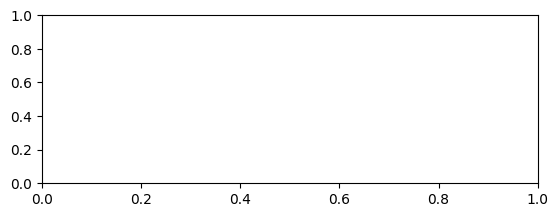

In [4]:
# (1) 光谱（能量分布）
plt.subplot(2,1,1)
# plt.plot((bins[:-1] + bins[1:]) / 2, pdf, color='purple')
plt.plot(bins , pdf, color='purple')
plt.xlabel('Energy (keV)')
plt.ylabel('Relative Intensity')
plt.title('Input X-ray Spectrum (PDF)')

# (2) 时间波形
plt.subplot(2,1,2)
plt.plot(t*1e6, sig_avg, label='Input Pulses')
plt.axhline(25, color='r', linestyle='--', label='~25 keV Threshold')
plt.xlabel('Time (μs)')
plt.ylabel('Amplitude (arb.)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from poisson_signal_generator_utils import count_crossings

# --- 阈值扫描参数 ---
dt = t[1] - t[0]                   # 采样间隔
thr_min = 1.0
# thr_max = 257
thr_max = sig_avg.max() #* 1.05
n_thr   = 256                      # 阈值点数（可调）
thr_vals = np.linspace(thr_min, thr_max, n_thr)



# --- 扫描阈值，得到积分谱 N(>T) ---
integral_counts = np.array([count_crossings(sig_avg, thr) for thr in thr_vals])

# --- 微分谱：对积分谱随阈值做负梯度 ---
# 用梯度近似 -dN/dT（注意单位 ~ counts/幅度）
differential = -np.gradient(integral_counts, thr_vals)

# 如果你的 gain=1，那么“幅度=能量(keV)”；否则这里可做 thr_vals/gain 的能量轴换算
energy_axis = thr_vals  # keV（在你的 generate_signal 里 gain=1.0）

# --- 画图：积分谱 & 微分谱（与输入pdf作形状对比）---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# 积分谱（阈值越高，计数越少）
ax1.plot(energy_axis, integral_counts, lw=1.8)
ax1.set_ylabel('Integral counts  N(>T)')
ax1.set_title('Integral Spectrum via Threshold Scan')

# 微分谱（应近似输入能谱形状；仅差一个尺度因子）
ax2.plot(energy_axis, differential, lw=1.8, label='Differential ( -dN/dT )')

# 可选：把输入 pdf 归一后缩放到可见范围作对比（仅形状对比）
# 这里简单按最大值对齐
orig_centers = (bins[:-1] + bins[1:]) / 2
pdf_norm = pdf / pdf.max() * differential.max() if differential.max() > 0 else pdf
ax2.plot(bins, pdf_norm , '--', label='Input PDF (scaled)')

ax2.set_xlabel('Threshold / Energy (keV)')
ax2.set_ylabel('Counts per keV (arb.)')
ax2.set_title('Differential Spectrum (shape ≈ input spectrum)')
ax2.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# energies: 形如 [12,13,...,120] keV 的中心点
# values:   同长度的 N_i，单位 [keV·cm^2·mAs]^-1 @ 1 m
# 示例：energies, values = load_spectrum('spek_120.txt')  # 你前面已经有

# 1) 构造能量 bin 边界与步长
if np.allclose(np.diff(energies), energies[1]-energies[0]):
    dE = np.diff(np.concatenate([energies, [energies[-1] + (energies[1]-energies[0])]]))
else:
    # 不等间隔：用相邻中心点做边界
    mid = (energies[:-1] + energies[1:]) / 2
    edges = np.empty(len(energies) + 1)
    edges[1:-1] = mid
    edges[0] = energies[0] - (mid[0] - energies[0])
    edges[-1] = energies[-1] + (energies[-1] - mid[-1])
    dE = np.diff(edges)

# 2) 物理参数（按需要替换）
I_mA   = 20.0           # 管电流 mA（连续透视时）
r_m    = 0.40           # 源到探测器距离（m）
A_cm2  = 340e-4*340e-4     # 例如单像素 0.5 mm × 0.5 mm = 0.05 cm × 0.05 cm
eta    = np.ones_like(values)  # 暂时不考虑效率时取 1

# 3) 计算入射计数率 λ（counts/s）
rate = np.sum(values * dE * I_mA * (1.0/r_m)**2 * A_cm2 * eta)

# 4) 生成 pdf（只要形状）
pdf = values * dE
pdf = pdf / pdf.sum()

# 5) 构造 bins（边界）传给 generate_signal
# 若 energies 是中心点：
bin_edges = np.empty(len(energies) + 1)
bin_edges[1:-1] = (energies[:-1] + energies[1:]) / 2
bin_edges[0] = energies[0] - (bin_edges[1] - energies[0])
bin_edges[-1] = energies[-1] + (energies[-1] - bin_edges[-2])

# 6) 调用你的生成函数
t, sig, times, amps = generate_signal(
    spectrum_bins=bin_edges,
    spectrum_pdf=pdf,
    rate=rate,                 # 这里就是“真实计数率/像素”
    T_total=400e-6,
    pulse_width=25e-9,
    dt=1e-9,
    gain=1.0
)

print(f"Computed rate = {rate:.3e} cps")
print(f"Generated {len(times)} events in {400e-6:.2e} s (observed ~ {len(times)/(400e-6):.3e} cps)")
